# **StyleGANXL + CLIP 🖼️**

## Generate images from text prompts using StyleGANXL with CLIP guidance.

This notebook is a work in progress, head over [here](https://github.com/CasualGANPapers/unconditional-StyleGAN-CLIP) if you want to be up to date with its changes.

Largely based on code by  [Katherine Crowson](https://github.com/crowsonkb) and [nshepperd](https://github.com/nshepperd).

Mostly made possible because of [StyleGAN-XL](https://github.com/autonomousvision/stylegan_xl) and [CLIP](https://github.com/openai/CLIP).

Created by [Eugenio Herrera](https://github.com/ouhenio) and [Rodrigo Mello](https://github.com/ryudrigo).


In [ ]:
#@markdown #**Install libraries and define functions** 🏗️🛠️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

!git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

## I'll probably have to trim stuff here

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 131 (delta 29), reused 108 (delta 14), pack-reused 0
Receiving objects: 100% (131/131), 4.17 MiB | 16.36 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 19.87 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Obtaining file:///content/CLIP
     |████████████████████████████████| 53 kB 1.3 MB/s 
  Running setup.py develop for clip
     |████████████████████████████████| 108 kB 7.6 MB/s 
     |████████████████████████████████| 431 kB 5.2 MB/s 


Using device: cuda:0
100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.8MiB/s]


In [ ]:
#@markdown #**Model selection** 🎭

Model = 'Imagenet' #@param ["Imagenet", "Pokemon", "FFHQ"]

#@markdown ---

network_url = {
    "Imagenet": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

--2022-04-03 17:46:54--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.29
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1896392968 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet128.pkl’

imagenet128.pkl     100%[===================>]   1.77G  27.1MB/s    in 69s     

2022-04-03 17:48:03 (26.3 MB/s) - ‘imagenet128.pkl’ saved [1896392968/1896392968]

Setting up PyTorch plugin "bias_act_plugin"... Done.


Your random seed is: 3990512268
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
torch.Size([1, 512])


  0%|          | 0/1001 [00:00<?, ?it/s]

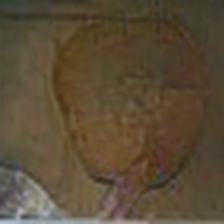

Image 0/1001 | Current loss: 0.8832979202270508


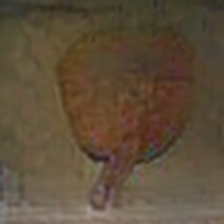

Image 10/1001 | Current loss: 0.8387094140052795


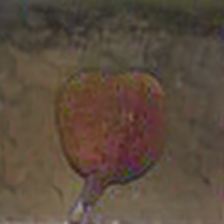

Image 20/1001 | Current loss: 0.8218386769294739


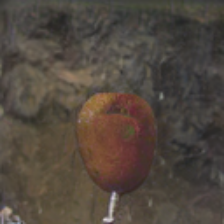

Image 30/1001 | Current loss: 0.8123907446861267


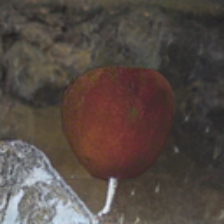

Image 40/1001 | Current loss: 0.7501059174537659


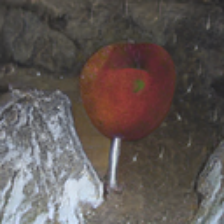

Image 50/1001 | Current loss: 0.7620768547058105


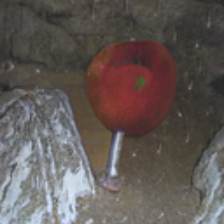

Image 60/1001 | Current loss: 0.7425252795219421


In [ ]:
#@markdown #**Run the model** 🚀
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

texts = "a red apple"#@param {type:"string"}
steps = 1001#@param {type:"number"}
seed = -1#@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


'''
zs = torch.randn([10000, G.mapping.z_dim], device=device)
one_hot_class = torch.zeros(1000)
initial_class = torch.randint(0,1000, (1,))[0]
one_hot_class[initial_class]=1
one_hot_class = one_hot_class.repeat((10000, 1))
cs = one_hot_class.to(device)
w_stds = G.mapping(zs, cs)
w_stds=w_stds.std(0)[0]
'''




tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

initial_batch=4 #actually that will be multiplied by initial_image_steps
initial_image_steps=8
'''
c = torch.zeros((1000)) #just to pick a closer initial image
c[initial_class]=1
c = c.repeat(initial_batch, 1)
c=c.to(device)
'''
def run(timestring):
  torch.manual_seed(seed)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(initial_image_steps):
      a = torch.randn([initial_batch, 512], device=device)*0.6 + w_stds*0.4
      q = ((a-w_all_classes_avg)/w_stds)
      images = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    # print(losses)
    # print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()


  # Sampling loop
  q_ema = q
  print (q.shape)
  opt = torch.optim.AdamW([q], lr=0.05, betas=(0.5,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]), noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis((q_ema * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]), noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass